In [64]:
import QDNS
import logging
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [65]:
class Alice(QDNS.Node):
    def __init__(self):
        super().__init__("Alice")
        self.create_new_application(self.alice_default_app)
        
    @staticmethod
    def alice_default_app(app: QDNS.Application):
        my_pairs = app.send_entangle_pairs(512, "Bob")
        
        if my_pairs is None:
            print("Something gone wrong on Alice side.")
            return
        
        result = app.measure_qubits(my_pairs)
        app.put_simulation_result(result)

In [66]:
class Bob(QDNS.Node):
    def __init__(self):
        super().__init__("Bob")
        self.create_new_application(self.bob_default_app)
        
    @staticmethod
    def bob_default_app(app: QDNS.Application):
        op = app.wait_next_qubits(512)
        
        if op is None:
            print("Bob did not receive qubits.")
            return
        
        my_pairs, count = op[0], op[1]
        
        result = app.measure_qubits(my_pairs)
        app.put_simulation_result(result)

In [67]:
def main(length_):
    logging.basicConfig(level=logging.WARNING)
    
    alice, bob = Alice(), Bob()
    net = QDNS.Network(alice, bob)
    net.add_channels(alice, bob, length=length_) #km
    
    core_count = int(QDNS.core_count/2)
    
    frames = {
        2: {
            2: int(600 / core_count)
        }
    }
    backend_conf = QDNS.BackendConfiguration(QDNS.CIRQ_BACKEND, core_count, frames)
    
    my_noise = QDNS.NoisePattern(
        0, 0, 0,
        sp_channel=QDNS.depolarisation_channel,
        measure_channel=QDNS.bit_and_phase_flip_channel,
        gate_channel=QDNS.phase_flip_channel,
        scramble_channel=QDNS.depolarisation_channel,
    )
    sim = QDNS.Simulator()
    results = sim.simulate(net, backend_conf, my_noise)
    
    alice_res = results.user_dumpings(alice.label, QDNS.DEFAULT_APPLICATION_NAME)
    bob_res = results.user_dumpings(bob.label, QDNS.DEFAULT_APPLICATION_NAME)
    
    count = 0
    for i in range(alice_res.__len__()):
        if alice_res[i] == bob_res[i]:
            count += 1
    rate = count / alice_res.__len__() * 100
    return rate

In [68]:
def run_more():
    results = list()
    lengths = list()
    for i in range(1, 61, 5):
        lengths.append(i)
        rate = main(i)
        results.append(rate)
    return lengths, results

In [69]:
plot_x, plot_y = run_more()

Text(0, 0.5, 'Match rate(%)')

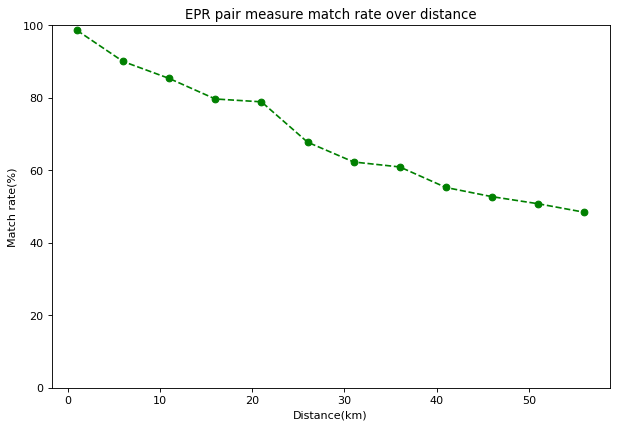

In [71]:
figure(figsize=(9, 6), dpi=80)
plt.title("EPR pair measure match rate over distance")
plt.plot(plot_x, plot_y, 'go--')
plt.ylim(0, 100)
plt.xlabel("Distance(km)")
plt.ylabel("Match rate(%)")